In [2]:
project_name = 'AI_group8_generator'

In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
import opendatasets as od

# dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
# od.download(dataset_url)

In [6]:
import os

DATA_DIR = 'C:/Users/wyes3/Desktop/ggyy'
# print(os.listdir(DATA_DIR))

In [7]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0034309.jpg', '0034958.jpg', '0037511.jpg', '0037512.jpg', '0038598.jpg', '0038626.jpg', '0038671.jpg', '0041419.jpg', '0043750.jpg', '0043890.jpg']


In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

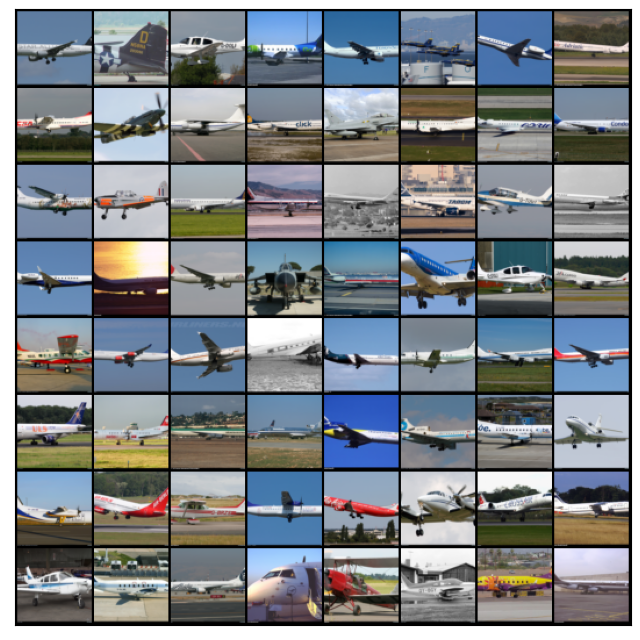

In [14]:
show_batch(train_dl)

In [15]:
!pip install jovian --upgrade --quiet

In [16]:
import jovian

<IPython.core.display.Javascript object>

In [17]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [19]:
device = get_default_device()

device(type='cpu')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [20]:
train_dl = DeviceDataLoader(train_dl, device)

In [21]:
import torch.nn as nn

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [23]:
discriminator = to_device(discriminator, device)

In [24]:
latent_size = 128

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


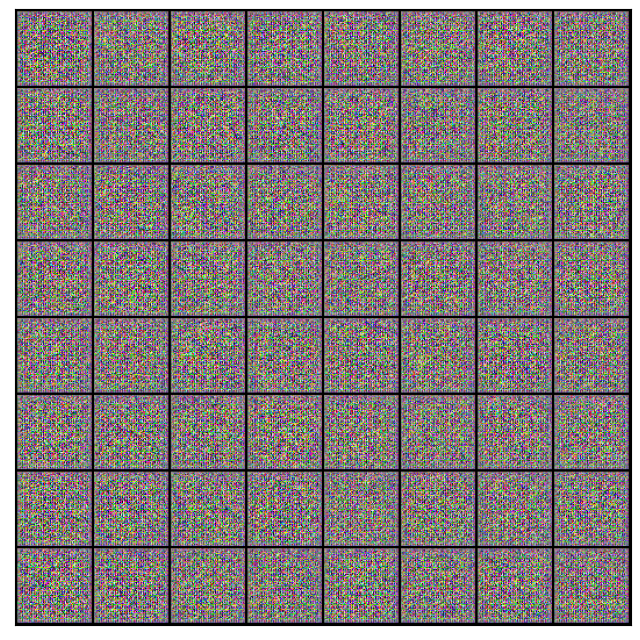

In [26]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [27]:
generator = to_device(generator, device)

In [28]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [29]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [30]:
from torchvision.utils import save_image

In [35]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"


In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 25

In [39]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [40]:
history = fit(epochs, lr)

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 11.4128, loss_d: 0.0262, real_score: 0.9750, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 2.6808, loss_d: 0.2734, real_score: 0.8125, fake_score: 0.0448
Saving generated-images-0002.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.2089, loss_d: 0.3130, real_score: 0.9329, fake_score: 0.1932
Saving generated-images-0003.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 1.2846, loss_d: 0.3658, real_score: 0.8838, fake_score: 0.2035
Saving generated-images-0004.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.4402, loss_d: 0.6519, real_score: 0.7485, fake_score: 0.2166
Saving generated-images-0005.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.8534, loss_d: 0.6157, real_score: 0.9415, fake_score: 0.4010
Saving generated-images-0006.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.8830, loss_d: 0.7899, real_score: 0.9878, fake_score: 0.4882
Saving generated-images-0007.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 1.3406, loss_d: 0.7099, real_score: 0.6434, fake_score: 0.1514
Saving generated-images-0008.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.4801, loss_d: 0.5472, real_score: 0.6946, fake_score: 0.0834
Saving generated-images-0009.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 2.7462, loss_d: 0.3214, real_score: 0.8277, fake_score: 0.0557
Saving generated-images-0010.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.9957, loss_d: 0.4369, real_score: 0.8677, fake_score: 0.2328
Saving generated-images-0011.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.7888, loss_d: 0.4027, real_score: 0.9232, fake_score: 0.2554
Saving generated-images-0012.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 1.1234, loss_d: 0.8609, real_score: 0.5788, fake_score: 0.1749
Saving generated-images-0013.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.8436, loss_d: 0.5800, real_score: 0.9167, fake_score: 0.3639
Saving generated-images-0014.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.1827, loss_d: 0.1867, real_score: 0.9158, fake_score: 0.0882
Saving generated-images-0015.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.7637, loss_d: 0.1040, real_score: 0.9430, fake_score: 0.0402
Saving generated-images-0016.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.7359, loss_d: 0.1056, real_score: 0.9812, fake_score: 0.0787
Saving generated-images-0017.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.7222, loss_d: 0.1904, real_score: 0.8877, fake_score: 0.0556
Saving generated-images-0018.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.5665, loss_d: 0.6735, real_score: 0.8613, fake_score: 0.3748
Saving generated-images-0019.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 5.0457, loss_d: 0.3469, real_score: 0.9641, fake_score: 0.2460
Saving generated-images-0020.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.4109, loss_d: 0.3240, real_score: 0.9658, fake_score: 0.2292
Saving generated-images-0021.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.9789, loss_d: 0.0955, real_score: 0.9246, fake_score: 0.0142
Saving generated-images-0022.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.2376, loss_d: 0.4604, real_score: 0.8473, fake_score: 0.2264
Saving generated-images-0023.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.3836, loss_d: 0.1532, real_score: 0.9682, fake_score: 0.1076
Saving generated-images-0024.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 3.8555, loss_d: 0.1186, real_score: 0.9370, fake_score: 0.0457
Saving generated-images-0025.png


In [41]:
losses_g, losses_d, real_scores, fake_scores = history

In [42]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [43]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [44]:
from IPython.display import Image

In [50]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

The final part to generate the Aircraft and get 10 pic

In [55]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
fake_fname = 'out.png'
save_image(denorm(fake_images), os.path.join('./group8/Aircraft/', fake_fname), nrow=8)
from PIL import Image
pic_row = Image.open('./group8/Aircraft/'+ fake_fname)
# pic = Image('./generated/generated-images-0025.png')
pic = pic_row.resize((512, 512))
for i in range(0,10):
    x = i%8
    y = int(i/8)
    cordinate_x = x * 64
    cordinate_y = y * 64
    pic1 = pic.crop([cordinate_x, cordinate_y, cordinate_x+64, cordinate_y+64])
    filename = str(i+1) + '.jpg'
    filedir = './group8/Aircraft/' + filename
    pic1.save(filedir)